<a href="https://colab.research.google.com/github/Rimlee23/UNIFIED-TRANSFER-LEARNING-SCHEME-FOR-DETECTING-DEFECTS-FROM-BOTH-THERMAL-AND-RGB-IMAGES/blob/rimlee/Thermal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import scipy.io
import matplotlib.pyplot as plt
import os
import glob
import torch.optim as optim
import torch.nn.functional as F
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import datasets,transforms, models

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Input
from tensorflow.keras.models import Model
from PIL import Image
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
from PIL import Image
import matplotlib.pyplot as plt



import os

import scipy
from skimage.transform import rotate
from os.path import join
from struct import unpack
import time

import codecs
import tensorflow as tf

In [ ]:
batch_size = 1
epochs = 30
channel_num=1810 # each infrared video has 1810 frames
crop_h = 128
crop_w = 128
learning_rate = 0.0001

In [ ]:
# Check if CUDA is available and set the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")  # Print the device being used

Using device: cuda


In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
directory = "/content/drive/My Drive/PVC-Infrared dataset"
images_path = directory

dict_keys(['__header__', '__version__', '__globals__', 'imageArray', 'Fs', 'numberImages'])


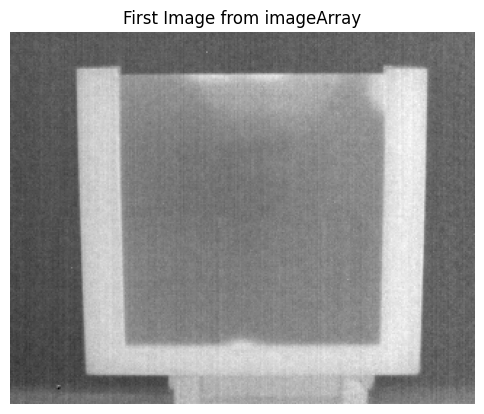

In [ ]:
# Load the .mat file
data = scipy.io.loadmat(os.path.join(directory, 'Z_019.mat'))
print(data.keys())
# Extract the image array
image_array = data['imageArray']

# Plot the first image from the array (assuming it's a 2D array of images)
plt.figure(figsize=(6, 6))
plt.imshow(image_array[:, :, 0], cmap='gray')  # Assuming grayscale, adjust if necessary
plt.title('First Image from imageArray')
plt.axis('off')  # Hide axes
plt.show()


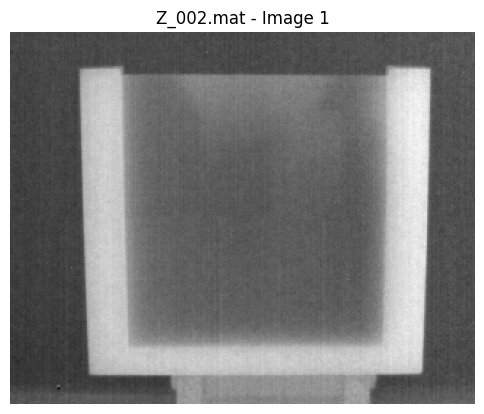

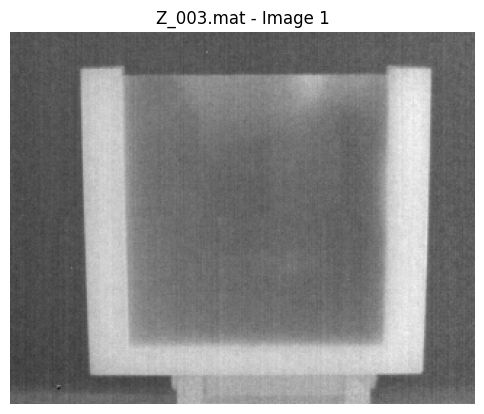

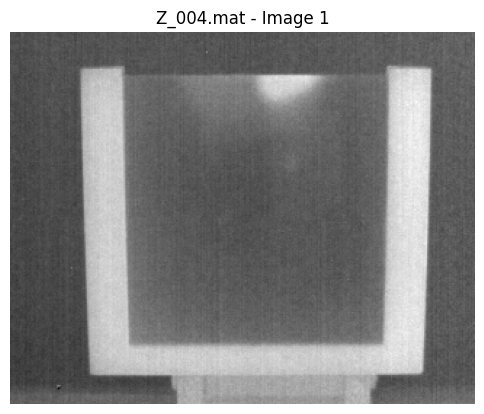

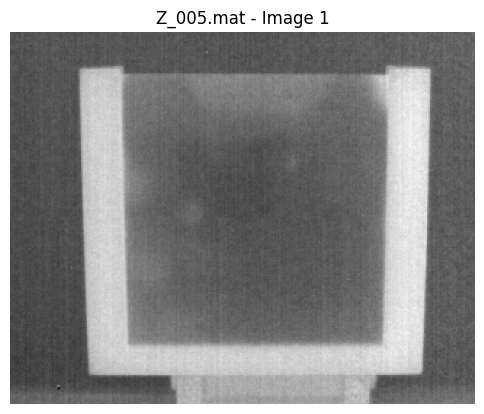

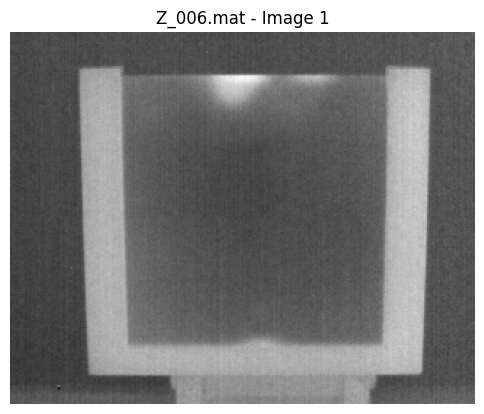

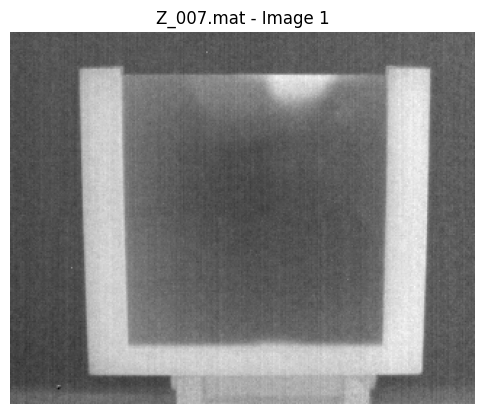

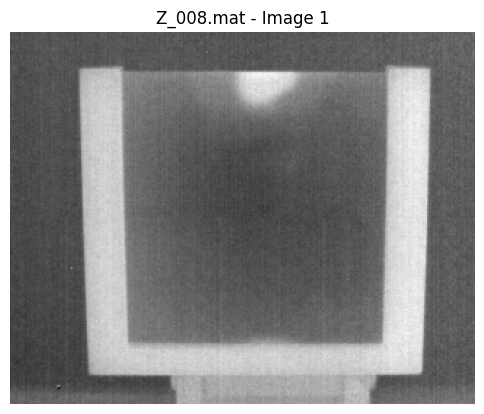

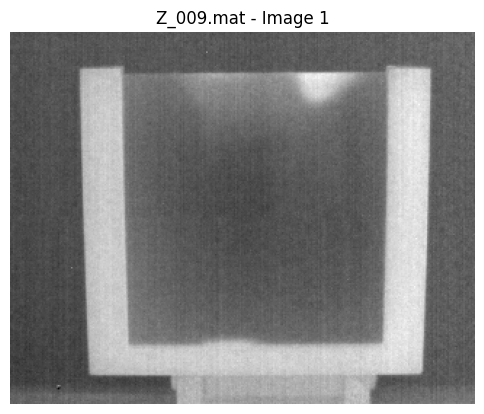

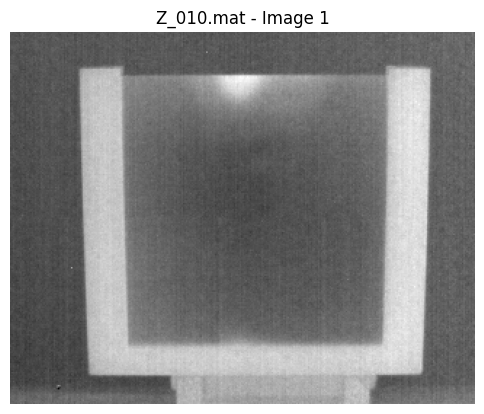

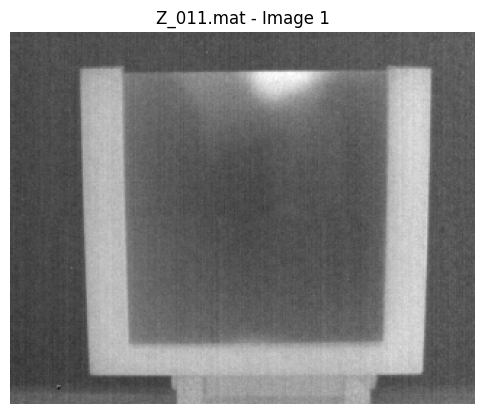

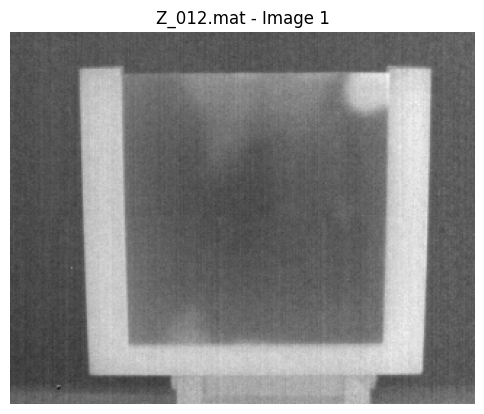

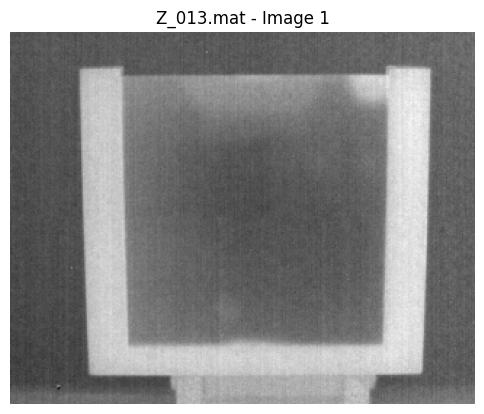

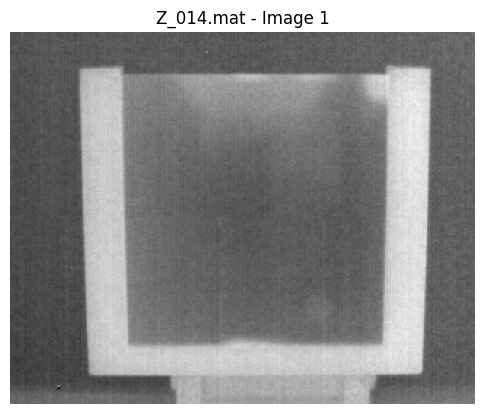

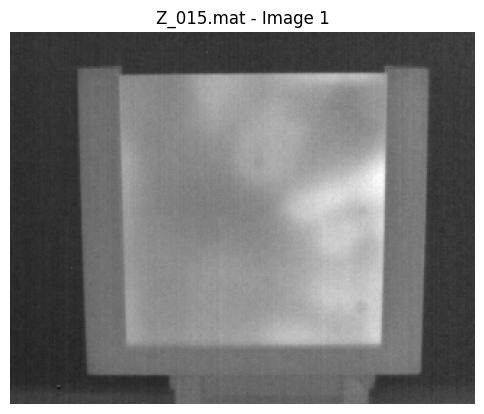

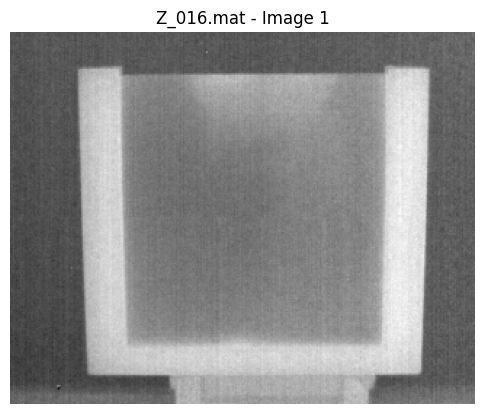

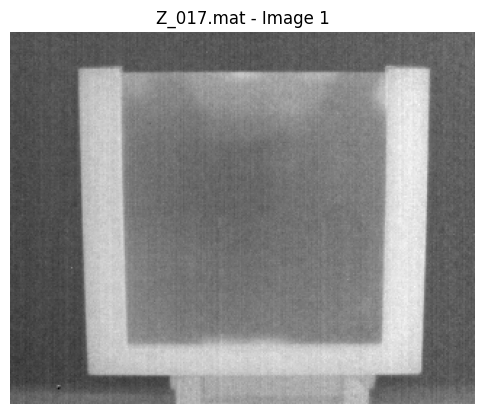

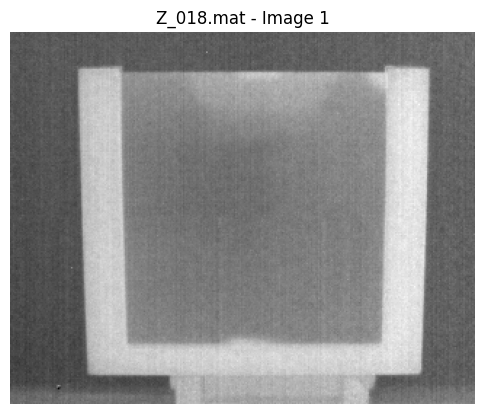

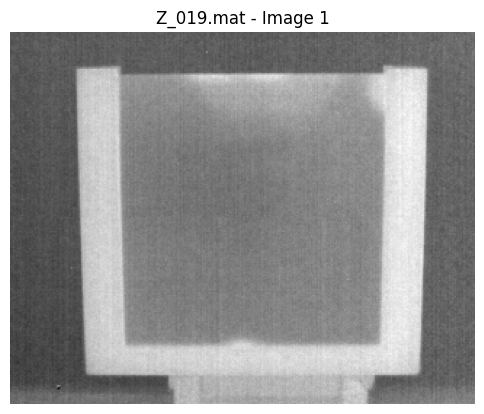

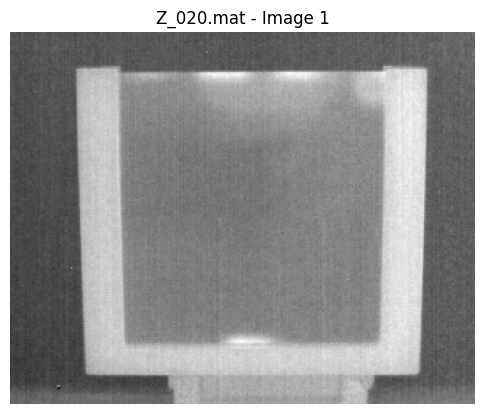

In [ ]:
# Directory where your .mat files are stored
mat_files_directory = '/content/drive/My Drive/PVC-Infrared dataset/'

# Find all .mat files in the directory
mat_files = glob.glob(os.path.join(mat_files_directory, '*.mat'))

# Loop through each .mat file
for mat_file in mat_files:
    # Load the .mat file
    data = scipy.io.loadmat(mat_file)

    # Check if the file contains 'imageArray' key
    if 'imageArray' in data:
        image_array = data['imageArray']
        number_of_images = int(data['numberImages'][0][0])  # Get the number of images

        # Plot each image in the array
        for i in range(number_of_images):
            plt.figure(figsize=(6, 6))
            plt.imshow(image_array[:, :, i], cmap='gray')  # Assuming grayscale
            plt.title(f'{os.path.basename(mat_file)} - Image {i + 1}')
            plt.axis('off')  # Hide axes
            plt.show()
    else:
        print(f"'imageArray' not found in {os.path.basename(mat_file)}")


In [ ]:
print("Images folder:", os.listdir(images_path)[:5])

Images folder: ['Z_002.mat', 'Z_003.mat', 'Z_002_mask.png', 'Z_004.mat', 'Z_003_mask.png']


In [ ]:
# Directory where your .mat files are stored
mat_files_directory = '/content/drive/My Drive/PVC-Infrared dataset/'
# Directory to save the images
output_directory = '/content/drive/My Drive/PVC-Infrared dataset/img/'

# Create output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

# Find all .mat files in the directory
mat_files = glob.glob(os.path.join(mat_files_directory, '*.mat'))

# Loop through each .mat file
for mat_file in mat_files:
    # Load the .mat file
    data = scipy.io.loadmat(mat_file)

    # Check if the file contains 'imageArray' key
    if 'imageArray' in data:
        image_array = data['imageArray']

        # Convert 'numberImages' to an integer (if nested)
        number_of_images = int(data['numberImages'][0][0])

        # Save each image in the array as a .png
        for i in range(number_of_images):
            # Create a filename based on the .mat file name and image index
            image_filename = os.path.basename(mat_file).replace('.mat', f'_image_{i + 1}.png')
            output_path = os.path.join(output_directory, image_filename)

            # Save the image
            plt.imsave(output_path, image_array[:, :, i], cmap='gray')
            print(f'Saved: {output_path}')
    else:
        print(f"'imageArray' not found in {os.path.basename(mat_file)}")


Saved: /content/drive/My Drive/PVC-Infrared dataset/img/Z_002_image_1.png
Saved: /content/drive/My Drive/PVC-Infrared dataset/img/Z_003_image_1.png
Saved: /content/drive/My Drive/PVC-Infrared dataset/img/Z_004_image_1.png
Saved: /content/drive/My Drive/PVC-Infrared dataset/img/Z_005_image_1.png
Saved: /content/drive/My Drive/PVC-Infrared dataset/img/Z_006_image_1.png
Saved: /content/drive/My Drive/PVC-Infrared dataset/img/Z_007_image_1.png
Saved: /content/drive/My Drive/PVC-Infrared dataset/img/Z_008_image_1.png
Saved: /content/drive/My Drive/PVC-Infrared dataset/img/Z_009_image_1.png
Saved: /content/drive/My Drive/PVC-Infrared dataset/img/Z_010_image_1.png
Saved: /content/drive/My Drive/PVC-Infrared dataset/img/Z_011_image_1.png
Saved: /content/drive/My Drive/PVC-Infrared dataset/img/Z_012_image_1.png
Saved: /content/drive/My Drive/PVC-Infrared dataset/img/Z_013_image_1.png
Saved: /content/drive/My Drive/PVC-Infrared dataset/img/Z_014_image_1.png
Saved: /content/drive/My Drive/PVC-Inf

In [ ]:
def unet_model(input_shape=(256, 256, 1)):
    inputs = Input(input_shape)

    # Contracting path (Encoder)
    # First block
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    # Second block
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)

    # Third block
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)

    # Fourth block
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)

    # Bottleneck
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)

    # Expanding path (Decoder)
    # First upsampling
    up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5)
    merge6 = concatenate([up6, conv4])
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

    # Second upsampling
    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
    merge7 = concatenate([up7, conv3])
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    # Third upsampling
    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
    merge8 = concatenate([up8, conv2])
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

    # Fourth upsampling
    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
    merge9 = concatenate([up9, conv1])
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

    # Output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs, outputs)
    return model

# Instantiate the model
input_shape = (256, 256, 1)  # Adjust to match your data
model = unet_model(input_shape)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 512)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 16, 16, 1024)   │      4,719,616 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 16, 16, 1024)   │      9,438,208 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 32, 32, 512)    │      2,097,664 │ conv2d_9[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 32, 32, 1024)   │              0 │ conv2d_transpose[0][0… │
│                      

 Total params: 31,030,593 (118.37 MB)

 Trainable params: 31,030,593 (118.37 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Define paths for images and labels
images_path = os.path.join(directory, 'img')
masks_path = directory

def load_image(image_path, mask_path):
    # Dummy function to load images and labels; replace with actual implementation
    # Example: using OpenCV or PIL to load images
    pass

def load_dataset(images_folder, masks_folder):
    images = []
    masks = []

    # Get all image files and filter labels to include only .png files
    image_files = os.listdir(images_folder)
    mask_files = [file for file in os.listdir(masks_folder) if file.endswith('.png')]

    for image_file, mask_file in zip(image_files, mask_files):
        image_path = os.path.join(images_folder, image_file)
        mask_path = os.path.join(masks_folder, mask_file)

        image, mask = load_image(image_path, mask_path)
        images.append(image)
        masks.append(mask)

    return np.array(images), np.array(masks)


In [ ]:
def load_image(image_path, mask_path):
    # Load image and label as grayscale (adjust as necessary)
    image = Image.open(image_path).convert('L')  # 'L' mode for grayscale
    mask = Image.open(mask_path).convert('L')

    # Convert to numpy arrays
    image = np.array(image)
    mask = np.array(mask)

    return image, mask

# Ensure the paths are set correctly and try loading the dataset
images, masks = load_dataset(images_path, masks_path)


In [ ]:
print(f"Loaded {images.shape[0]} images and {masks.shape[0]} masks.")

Loaded 19 images and 19 masks.


In [ ]:
# Convert lists to numpy arrays and expand dimensions for compatibility with U-Net
images = np.array(images).reshape(-1, 256, 320, 1)  # Shape (num_samples, 256, 320, 1)
masks = np.array(masks).reshape(-1, 256, 320, 1) / 255  # Normalize mask values to [0, 1]

images_resized = []
masks_resized = []
for img, msk in zip(images, masks):
    img_resized = cv2.resize(img, (256, 256))
    msk_resized = cv2.resize(msk, (256, 256))
    images_resized.append(img_resized)
    masks_resized.append(msk_resized)

images = np.array(images_resized).reshape(-1, 256, 256, 1)
masks = np.array(masks_resized).reshape(-1, 256, 256, 1)

In [ ]:
# Split the dataset into training and validation sets
train_images, val_images, train_masks, val_masks = train_test_split(images, masks, test_size=0.2, random_state=42)

In [ ]:
history = model.fit(train_images, train_masks, validation_data=(val_images, val_masks), epochs=20, batch_size=16)

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 94s 94s/step - accuracy: 0.0255 - loss: 7.2959 - val_accuracy: 0.9845 - val_loss: 0.2779
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 54s 54s/step - accuracy: 0.9752 - loss: 0.4876 - val_accuracy: 0.9845 - val_loss: 0.2830
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9752 - loss: 0.4974 - val_accuracy: 0.9845 - val_loss: 0.1954
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9752 - loss: 0.3435 - val_accuracy: 0.9809 - val_loss: 0.1141
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 817ms/step - accuracy: 0.9713 - loss: 0.1615 - val_accuracy: 0.9828 - val_loss: 0.1135
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 809ms/step - accuracy: 0.9737 - loss: 0.1529 - val_accuracy: 0.9845 - val_loss: 0.1214
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 886ms/step - accuracy: 0.9752 - loss: 0.2124 - val_accuracy: 0.9845 - val_loss: 0.1092
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 825ms/step - accuracy: 0.9752 - loss: 0.1902 - val_accuracy: 0.9842 - val_loss: 0.1078


In [ ]:
# Evaluate the model on the training set
evaluation_results = model.evaluate(train_images, train_masks)

loss = evaluation_results[0]
accuracy = evaluation_results[1]
print(f"Training Loss: {loss}, Training Accuracy: {accuracy}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step - accuracy: 0.9752 - loss: 0.5169
Training Loss: 0.5169252753257751, Training Accuracy: 0.9751800298690796


In [ ]:
# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(val_images, val_masks)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9845 - loss: 0.2942
Validation Loss: 0.2941671311855316, Validation Accuracy: 0.9845123291015625


In [ ]:
def iou_metric(y_true, y_pred):
    # Convert predictions to binary values
    y_pred = tf.cast(y_pred > 0.5, tf.float32)

    # Calculate intersection and union
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true + y_pred) - intersection

    # Compute IoU
    iou = (intersection + K.epsilon()) / (union + K.epsilon())
    return iou

# Compile the model with IoU as a metric
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', iou_metric])

In [ ]:
history = model.fit(train_images, train_masks, validation_data=(val_images, val_masks), epochs=20, batch_size=16)

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - accuracy: 0.9752 - iou_metric: 4.3911e-12 - loss: 0.5169 - val_accuracy: 0.0359 - val_iou_metric: 0.0146 - val_loss: 11.1821
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 891ms/step - accuracy: 0.0434 - iou_metric: 0.0237 - loss: 11.2347 - val_accuracy: 0.9845 - val_iou_metric: 2.6643e-11 - val_loss: 0.1687
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 812ms/step - accuracy: 0.9752 - iou_metric: 4.3911e-12 - loss: 0.2948 - val_accuracy: 0.9845 - val_iou_metric: 2.6643e-11 - val_loss: 0.3176
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9752 - iou_metric: 4.3911e-12 - loss: 0.5577 - val_accuracy: 0.9845 - val_iou_metric: 2.6643e-11 - val_loss: 0.3988
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9752 - iou_metric: 4.3911e-12 - loss: 0.7005 - val_accuracy: 0.9845 - val_iou_metric: 2.6643e-11 - val_loss: 0.4385
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 933ms/step - accuracy: 0.9752 - iou_metric: 4.3911e-12 - loss: 0.7699 - va

In [ ]:
val_loss, val_accuracy, val_iou = model.evaluate(val_images, val_masks)
print(f"Validation IoU: {val_iou:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9845 - iou_metric: 2.6643e-11 - loss: 0.1043
Validation IoU: 0.0000


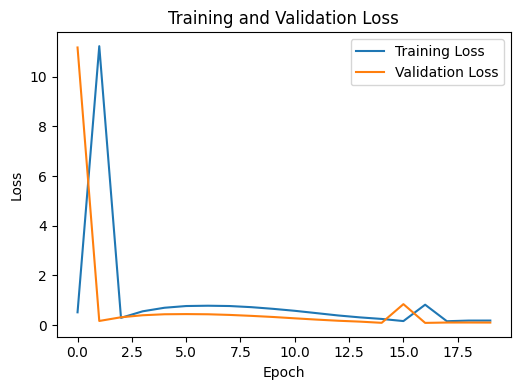

In [ ]:
# Plot training & validation loss
plt.figure(figsize=(10, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
image = val_images[0]
prediction = model.predict(np.expand_dims(image, axis=0))[0]
print(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[[[2.96319705e-02]
  [6.80261664e-03]
  [4.25656280e-03]
  ...
  [7.19232345e-03]
  [7.93042406e-03]
  [2.56354399e-02]]

 [[3.53846443e-03]
  [1.90320381e-04]
  [1.80053758e-04]
  ...
  [1.91576473e-04]
  [2.20034548e-04]
  [2.33681174e-03]]

 [[2.83532566e-03]
  [1.83614320e-04]
  [2.19740818e-04]
  ...
  [2.60251923e-04]
  [1.06210682e-04]
  [1.11190381e-03]]

 ...

 [[3.02150100e-03]
  [1.33213063e-04]
  [1.54632085e-04]
  ...
  [2.96752725e-04]
  [3.30537732e-05]
  [3.56911769e-04]]

 [[2.17215833e-03]
  [1.14541464e-04]
  [1.87610916e-04]
  ...
  [1.55286514e-04]
  [4.27205341e-05]
  [1.16558385e-03]]

 [[3.68757267e-03]
  [6.43751875e-04]
  [1.24595186e-03]
  ...
  [8.28952296e-04]
  [6.37648394e-04]
  [8.44434835e-03]]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


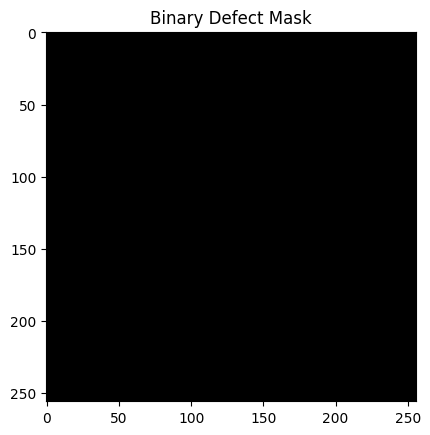

Classification: Defective


In [ ]:

image = val_images[0]

# Expand dimensions to match model input requirements and predict
prediction = model.predict(np.expand_dims(image, axis=0))[0]

# Threshold the prediction to create a binary mask
threshold = 0.0001e-30  # Set threshold based on model performance
binary_mask = (prediction > threshold).astype(int)

# Display the binary mask to verify the result
plt.imshow(binary_mask, cmap='gray')
plt.title("Binary Defect Mask")
plt.show()

# Calculate defect area ratio to classify image
defect_pixel_count = np.sum(binary_mask)
total_pixel_count = binary_mask.size
defect_area_ratio = defect_pixel_count / total_pixel_count

# Define defect threshold for classification
defect_threshold = 0.05  # Adjust this based on validation
is_defective = defect_area_ratio > defect_threshold

print("Classification:", "Defective" if is_defective else "Not Defective")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Image 1:
 - Accuracy: 99.44%
 - IoU: 0.00


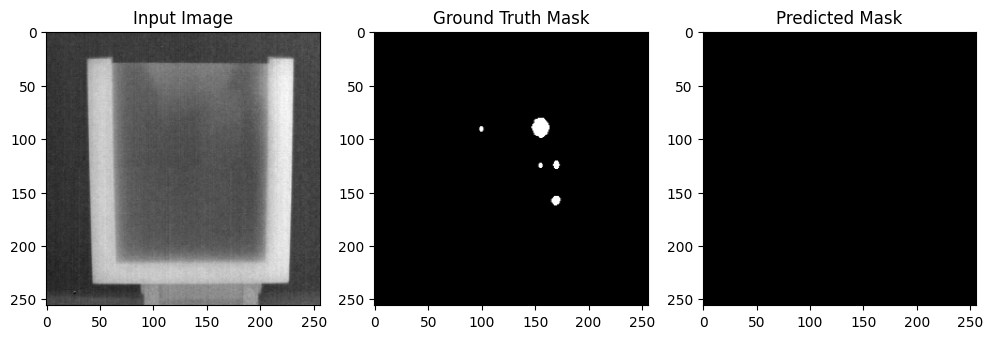

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Image 2:
 - Accuracy: 98.99%
 - IoU: 0.00


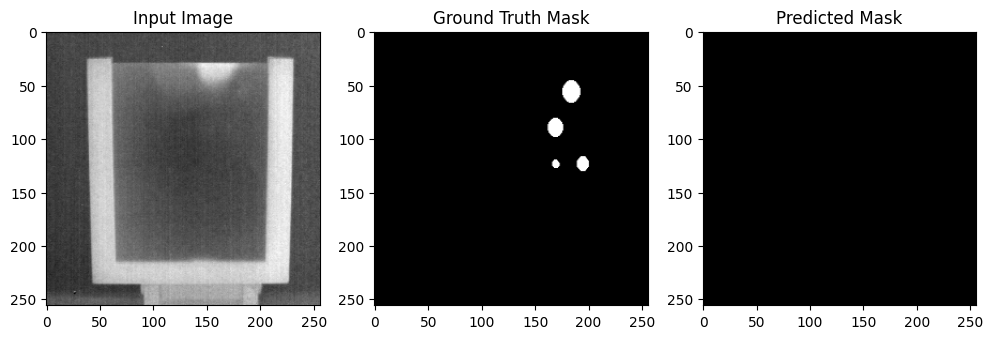

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Image 3:
 - Accuracy: 97.04%
 - IoU: 0.00


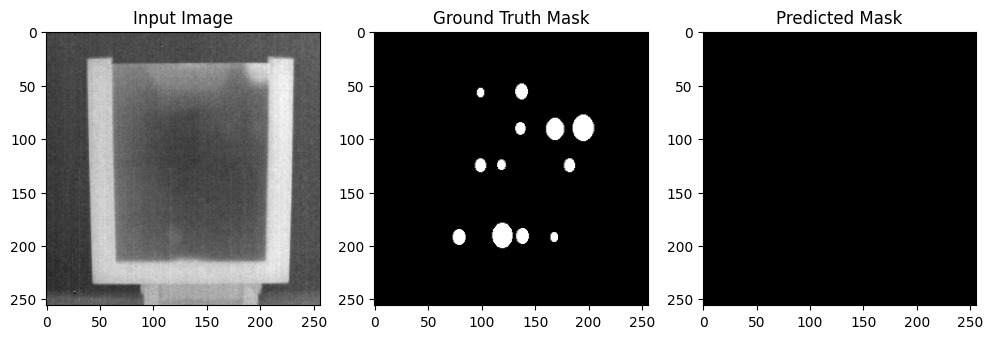

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Image 4:
 - Accuracy: 98.79%
 - IoU: 0.00


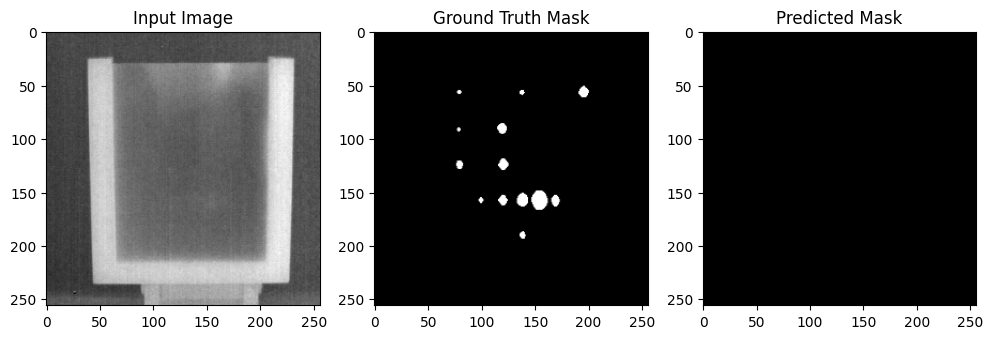

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate accuracy and IoU
def evaluate_segmentation(predicted_mask, ground_truth_mask):
    # Ensure the masks are binary
    predicted_mask = (predicted_mask > 0.5).astype(int)
    ground_truth_mask = (ground_truth_mask > 0.5).astype(int)

    # Calculate pixel-wise accuracy
    total_pixels = ground_truth_mask.size
    matching_pixels = np.sum(predicted_mask == ground_truth_mask)
    accuracy = matching_pixels / total_pixels * 100  # Percentage

    # Calculate Intersection over Union (IoU)
    intersection = np.sum((predicted_mask & ground_truth_mask))
    union = np.sum((predicted_mask | ground_truth_mask))
    iou = intersection / union if union != 0 else 0

    return accuracy, iou

# Loop over validation images
threshold = 4.3911e-12 # Threshold for binary mask
for i, (image, ground_truth) in enumerate(zip(val_images, val_masks)):
    # Predict mask for the image
    predicted_mask = model.predict(np.expand_dims(image, axis=0))[0]

    # Evaluate the prediction
    accuracy, iou = evaluate_segmentation(predicted_mask, ground_truth)

    # Display results
    print(f"Image {i + 1}:")
    print(f" - Accuracy: {accuracy:.2f}%")
    print(f" - IoU: {iou:.2f}")

    # Plot ground truth and predicted masks
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title("Input Image")

    plt.subplot(1, 3, 2)
    plt.imshow(ground_truth.squeeze(), cmap='gray')
    plt.title("Ground Truth Mask")

    plt.subplot(1, 3, 3)
    plt.imshow((predicted_mask > threshold).squeeze(), cmap='gray')
    plt.title("Predicted Mask")

    plt.show()


In [ ]:
model.save('/content/drive/My Drive/PVC-Infrared dataset/working/')

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=/content/drive/My Drive/PVC-Infrared dataset/working/.